<a href="https://colab.research.google.com/github/racoope70/daytrading-with-ml/blob/main/initial_day_trading_apple.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip  install yfinance
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf


In [2]:
 #Download most recent 1-hour stock data (Max available: last 720 days)
df = yf.download("AAPL", period="720d", interval="1h")

#Print actual column names to check the structure
print("Original column names:", df.columns)


[*********************100%***********************]  1 of 1 completed

Original column names: MultiIndex([( 'Close', 'AAPL'),
            (  'High', 'AAPL'),
            (   'Low', 'AAPL'),
            (  'Open', 'AAPL'),
            ('Volume', 'AAPL')],
           names=['Price', 'Ticker'])


In [3]:
#Fix Multi-Index Columns: Extract only the first level (Price Type)
df.columns = df.columns.get_level_values(0)  # Extract 'Close', 'High', 'Low', 'Open', 'Volume'

#Reset index to make "Datetime" a column
df = df.reset_index()

In [4]:
#Keep only relevant columns
df = df[['Datetime', 'Open', 'High', 'Low', 'Close', 'Volume']]

#Verify DataFrame
print(df.head())

Price                  Datetime        Open        High         Low  \
0     2022-03-28 13:30:00+00:00  172.169998  175.000000  172.000000   
1     2022-03-28 14:30:00+00:00  174.345001  175.005005  173.699997   
2     2022-03-28 15:30:00+00:00  174.375000  174.395004  173.080002   
3     2022-03-28 16:30:00+00:00  173.410004  174.600006  173.330002   
4     2022-03-28 17:30:00+00:00  174.440002  174.800003  174.150604   

Price       Close    Volume  
0      174.339996  25291677  
1      174.380005  11578517  
2      173.399994   8979815  
3      174.441803   6460224  
4      174.740097   7178077  


In [5]:
#Reset index to make "Datetime" a column
df = df.reset_index()

#Keep only relevant columns
df = df[['Datetime', 'Open', 'High', 'Low', 'Close', 'Volume']]

#Verify DataFrame
print(df.head())

Price                  Datetime        Open        High         Low  \
0     2022-03-28 13:30:00+00:00  172.169998  175.000000  172.000000   
1     2022-03-28 14:30:00+00:00  174.345001  175.005005  173.699997   
2     2022-03-28 15:30:00+00:00  174.375000  174.395004  173.080002   
3     2022-03-28 16:30:00+00:00  173.410004  174.600006  173.330002   
4     2022-03-28 17:30:00+00:00  174.440002  174.800003  174.150604   

Price       Close    Volume  
0      174.339996  25291677  
1      174.380005  11578517  
2      173.399994   8979815  
3      174.441803   6460224  
4      174.740097   7178077  


In [6]:
print(df.isnull().sum())  # Check for NaNs
df.dropna(inplace=True)  # Remove missing values

Price
Datetime    0
Open        0
High        0
Low         0
Close       0
Volume      0
dtype: int64


In [7]:
print(df.dtypes)  # Ensure Datetime is correctly formatted
df['Datetime'] = pd.to_datetime(df['Datetime'])  # Convert if necessary

Price
Datetime    datetime64[ns, UTC]
Open                    float64
High                    float64
Low                     float64
Close                   float64
Volume                    int64
dtype: object


In [8]:
df['SMA_10'] = df['Close'].rolling(window=10).mean()
df['SMA_50'] = df['Close'].rolling(window=50).mean()
df['EMA_10'] = df['Close'].ewm(span=10, adjust=False).mean()

delta = df['Close'].diff(1)
gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
rs = gain / loss
df['RSI'] = 100 - (100 / (1 + rs))

df['MACD'] = df['Close'].ewm(span=12, adjust=False).mean() - df['Close'].ewm(span=26, adjust=False).mean()

df['Bollinger_Upper'] = df['SMA_10'] + (df['Close'].rolling(10).std() * 2)
df['Bollinger_Lower'] = df['SMA_10'] - (df['Close'].rolling(10).std() * 2)


In [9]:
df['Buy_Signal'] = (df['SMA_10'] > df['SMA_50']) & (df['SMA_10'].shift(1) <= df['SMA_50'].shift(1))
df['Sell_Signal'] = (df['SMA_10'] < df['SMA_50']) & (df['SMA_10'].shift(1) >= df['SMA_50'].shift(1))


In [10]:
initial_capital = 10000
capital = initial_capital
shares = 0
trade_log = []

for i in range(len(df)):
    price = df['Close'].iloc[i]

    if df['Buy_Signal'].iloc[i]:  # Buy condition
        shares = capital // price  # Buy max shares
        capital -= shares * price
        trade_log.append(f"BUY at {price:.2f}")

    elif df['Sell_Signal'].iloc[i] and shares > 0:  # Sell condition
        capital += shares * price
        shares = 0
        trade_log.append(f"SELL at {price:.2f}")

# Ensure final sell execution if holding shares
if shares > 0:
    capital += shares * df['Close'].iloc[-1]
    trade_log.append(f"FINAL SELL at {df['Close'].iloc[-1]:.2f}")

print(f"Final Portfolio Value: ${capital:.2f}")
print(f"Profit/Loss: ${capital - initial_capital:.2f}")
print(f"Trade Log: {trade_log}")


Final Portfolio Value: $14409.55
Profit/Loss: $4409.55
Trade Log: ['BUY at 170.70', 'SELL at 164.07', 'BUY at 161.45', 'SELL at 157.74', 'BUY at 143.98', 'SELL at 146.56', 'BUY at 148.80', 'SELL at 146.16', 'BUY at 136.09', 'SELL at 136.62', 'BUY at 141.61', 'SELL at 151.52', 'BUY at 154.42', 'SELL at 168.73', 'BUY at 161.63', 'SELL at 155.93', 'BUY at 157.00', 'SELL at 153.67', 'BUY at 146.76', 'SELL at 140.08', 'BUY at 142.57', 'SELL at 145.00', 'BUY at 154.60', 'SELL at 148.86', 'BUY at 146.83', 'SELL at 148.02', 'BUY at 150.20', 'SELL at 145.13', 'BUY at 148.34', 'SELL at 142.31', 'BUY at 144.80', 'SELL at 137.90', 'BUY at 129.52', 'SELL at 142.39', 'BUY at 145.53', 'SELL at 150.76', 'BUY at 152.94', 'SELL at 152.54', 'BUY at 150.76', 'SELL at 147.93', 'BUY at 151.82', 'SELL at 151.36', 'BUY at 153.23', 'SELL at 156.78', 'BUY at 160.78', 'SELL at 160.82', 'BUY at 165.59', 'SELL at 165.02', 'BUY at 168.29', 'SELL at 165.67', 'BUY at 173.26', 'SELL at 172.18', 'BUY at 174.28', 'SELL 

In [11]:
profit_trades = sum([1 for i in range(1, len(trade_log), 2) if float(trade_log[i].split(" at ")[1]) > float(trade_log[i-1].split(" at ")[1])])
total_trades = len(trade_log) // 2  # Buy/Sell pairs
win_rate = (profit_trades / total_trades) * 100
print(f"Win Rate: {win_rate:.2f}%")


Win Rate: 42.11%


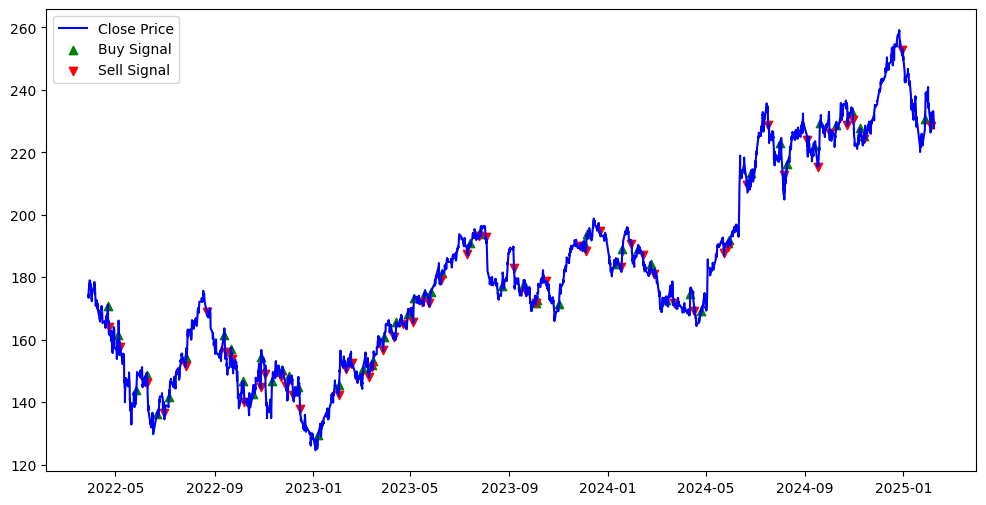

In [12]:
df['Buy_Signal'] = df['Buy_Signal'].astype(bool)
df['Sell_Signal'] = df['Sell_Signal'].astype(bool)

plt.figure(figsize=(12,6))
plt.plot(df['Datetime'], df['Close'], label='Close Price', color='blue')
plt.scatter(df[df['Buy_Signal']]['Datetime'], df[df['Buy_Signal']]['Close'], marker='^', color='green', label='Buy Signal')
plt.scatter(df[df['Sell_Signal']]['Datetime'], df[df['Sell_Signal']]['Close'], marker='v', color='red', label='Sell Signal')
plt.legend()
plt.show()
